# DFO Moorings

## Mooring CTD time series visulization - E01

In [1]:
#import python packages needed
import erddapy
from erddapy import ERDDAP
import numpy as np
import pandas as pd
import xarray
import cf_xarray
import datetime
import netCDF4
from netCDF4 import Dataset
from matplotlib import pyplot as plt

### 1. develop a function to download mooring data from ERDDAP server

In [2]:
def get_erddap_data(erddap_url, dataset, data_protocol="griddap", variables=None, constraints=None):
    """
    Function: get_erddap_data
    This function uses the erddapy python library to access data from ERDDAP servers,
    and to return it to users in convenient formats for python users.
    Data can be pulled from "tabledap" or "griddap" formats, with different
    output types, depending on the dap type.
    
    Inputs:
    erddap_url    - The url address of the erddap server to pull data from
    variables     - The selected variables within the dataset.
    data_protocol - The erddap data protocol for the chosen dataset.
                    Options include "tabledap" or "griddap"
                    The default option is given as "griddap"
    dataset       - The ID for the relevant dataset on the erddap server
                    If no variables are given, it is assumed that all variables
                    will be pulled.
    constraints   - These are set by the user to help restrict the data pull
                    to only the area and timeframe of interest.
                    If no constraints are given, all data in a dataset is pulled.
                    Constraints should be given as a dictionary, where
                    each entry is a bound and/or selection of a specific axis variable
                    Exs. {"longitude<=": "min(longitude)+10", "longitude>=": "0"}
                         {"longitude=": "140", "time>=": "max(time)-30"}
    
    Outputs:
    erddap_data   - This variable contains the pulled data from the erddap server.
                    If the data_protocol is "griddap",  then erddap_data is an xarray dataset
                    If the data_protocol is "tabledap", then erddap_data is a pandas dataframe
    """
    
    import erddapy
    from erddapy import ERDDAP
    import pandas as pd
    import xarray
    
    
    ############################################
    # Set-up the connection to the ERDDAP server
    ############################################
    
    # Connect to the erddap server
    e = ERDDAP(server=erddap_url, protocol=data_protocol, response='csv')
    
    # Identify the dataset of interest
    e.dataset_id = dataset
    
    
    #########################################
    # Pull the data, based upon protocol type
    #########################################
    
    # GRIDDAP Protocol
    if data_protocol == "griddap":
        
        # Initialize the connection
        e.griddap_initialize()

        # Update the constraints
        if constraints is not None:
            e.constraints.update(constraints)
            e.griddap_initialize()
            
        # Update the selection of the variables
        if variables is not None:
            e.variables = variables

        erddap_data = e.to_xarray()
    
    # TABLEDAP Protocol
    elif data_protocol == "tabledap":

        # Update the constraints
        if constraints is not None:
            e.constraints = constraints
            
        # Update the selection of the variables
        if variables is not None:
            e.variables = variables
            
        erddap_data = e.to_pandas()
    
    # Invalid protocol given
    else:
        print('Invalid ERDDAP protocol. Given protocol is: ' + data_protocol)
        print('Valid protocols include "griddap" or "tabledap". Please restart and try again with a valid protocol')
        erddap_data = None
    
    
    #############################
    return erddap_data

### 2. Set and map the data search polygon for E01

In [3]:
# show the bounding polygon for E01 data search

import folium

#set the boundary box
min_lat, max_lat = 49.28, 49.30
min_lon, max_lon = -126.62, -126.60

lon = (min_lon + max_lon) / 2
lat = (min_lat + max_lat) / 2

m = folium.Map(location=[lat, lon], tiles="OpenStreetMap", zoom_start=5)

folium.Polygon(
    [(min_lat, min_lon), (max_lat, min_lon), (max_lat, max_lon), (min_lat, max_lon)],
    fill=True,
).add_to(m)
m

### 3. E01 moored CTD data download

In [4]:
#get DFO mooring E01 data from cioos erddap server
cioos_url = 'https://data.cioospacific.ca/erddap'
cioos_dataset = 'IOS_CTD_Moorings'

variables = ["time",
             "depth",
             "latitude",
             "longitude",
             "sea_water_pressure",
             "sea_water_temperature",
             "sea_water_practical_salinity",
             "TEMPS901",
             "TEMPS902",
             "TEMPS601",
             "TEMPS602",
             "TEMPST01"]

#constraints = {"time>=":datetime.datetime(2022,1,1).strftime('%Y-%m-%dT%H:%M:%SZ')}
#constraints = {"time>=": "max(time)-365"}
constraints = {
    "latitude>=": 49.28,
    "latitude<=": 49.30,
    "longitude>=": -126.62,
    "longitude<=": -126.60,
}

cioos_table = get_erddap_data(cioos_url, cioos_dataset, 
                variables=variables,
                constraints=constraints,
                data_protocol="tabledap")

Check the downloaded data:

In [5]:
cioos_table

,time (UTC),depth (m),latitude (degrees_north),longitude (degrees_east),sea_water_pressure (dbar),sea_water_temperature (degC),sea_water_practical_salinity (PSS-78),TEMPS901 (deg_C),TEMPS902 (deg_C),TEMPS601 (deg_C),TEMPS602 (deg_C),TEMPST01 (deg_C)
0,2008-04-28T20:00:01Z,73.502020,49.288185,-126.60239,74.146,NaN,32.9249,NaN,NaN,NaN,NaN,7.5953
1,2008-04-28T20:00:21Z,73.502020,49.288185,-126.60239,74.146,NaN,32.9276,NaN,NaN,NaN,NaN,7.5958
2,2008-04-28T20:00:41Z,73.448494,49.288185,-126.60239,74.092,NaN,32.9293,NaN,NaN,NaN,NaN,7.5964
3,2008-04-28T20:01:01Z,73.484170,49.288185,-126.60239,74.128,NaN,32.9304,NaN,NaN,NaN,NaN,7.5981
4,2008-04-28T20:01:21Z,73.466330,49.288185,-126.60239,74.110,NaN,32.9298,NaN,NaN,NaN,NaN,7.5972
...,...,...,...,...,...,...,...,...,...,...,...,...
1128615,2022-07-14T23:00:07Z,97.252230,49.288330,-126.60290,98.110,7.1191,33.7387,7.1191,NaN,NaN,NaN,NaN
1128616,2022-07-14T23:30:07Z,97.026276,49.288330,-126.60290,97.882,7.1316,33.7315,7.1316,NaN,NaN,NaN,NaN
1128617,2022-07-15T00:00:07Z,96.897440,49.288330,-126.60290,97.752,7.1474,33.7214,7.1474,NaN,NaN,NaN,NaN
1128618,2022-07-15T00:30:07Z,96.605090,49.288330,-126.60290,97.457,7.1669,33.7088,7.1669,NaN,NaN,NaN,NaN


In [ ]:
cioos_table.columns

In [6]:
cioos_table_1 = cioos_table.rename(columns={'time (UTC)': 'time',
                                            'depth (m)': 'depth', 
                                            'latitude (degrees_north)': 'latitude',
                                            'longitude (degrees_east)': 'longitude',
                                            'sea_water_pressure (dbar)': 'sea_water_pressure',
                                            'sea_water_temperature (degC)': 'sea_water_temperature',
                                            'sea_water_practical_salinity (PSS-78)': 'sea_water_pratical_salinity',
                                            'TEMPS901 (deg_C)': 'TEMPS901',
                                            'TEMPS902 (deg_C)': 'TEMPS902',
                                            'TEMPS601 (deg_C)': 'TEMPS601',
                                            'TEMPS602 (deg_C)': 'TEMPS602',
                                            'TEMPST01 (deg_C)': 'TEMPST01'})

In [ ]:
cioos_table_1.columns

In [7]:
# could drop columns without real data
cioos_table_1 = cioos_table_1.drop(['TEMPS901', 'TEMPS902', 'TEMPS601', 'TEMPS602'], axis=1)

In [ ]:
cioos_table_1.columns

### 4. Check and plot the instrument depths @ E01

<Axes: >

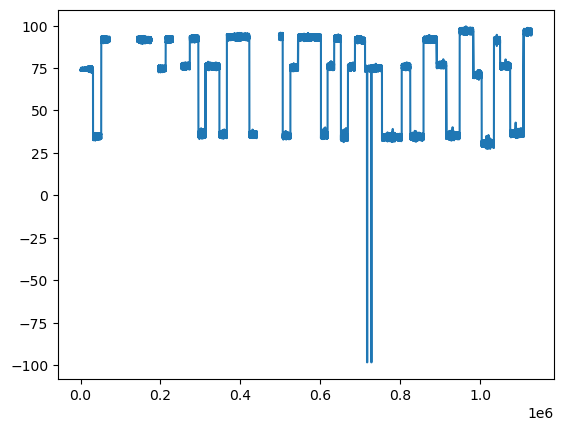

In [8]:
cioos_table_1.depth.plot()

### 5. Plot Temperature and Salinity time series at three different depths at E01

In [10]:
#cioos_e01_35 = cioos_table_1[(cioos_table_1["depth"] >= 30) & (cioos_table_1["depth"] <= 40)]
#cioos_e01_75 = cioos_table_1[(cioos_table_1["depth"] >= 70) & (cioos_table_1["depth"] <= 80)]
#cioos_e01_95 = cioos_table_1[(cioos_table_1["depth"] >= 90) & (cioos_table_1["depth"] <= 100)]
#newtime_35= pd.DatetimeIndex(cioos_e01_35['time'].values)

def plot_dfo_E01_mooring(depth):
    if depth == 35:
        cioos_e01 = cioos_table_1[(cioos_table_1["depth"] >= 30) & (cioos_table_1["depth"] <= 40)]
    elif depth == 75:
        cioos_e01 = cioos_table_1[(cioos_table_1["depth"] >= 70) & (cioos_table_1["depth"] <= 80)]
    elif depth == 95:
        cioos_e01 = cioos_table_1[(cioos_table_1["depth"] >= 90) & (cioos_table_1["depth"] <= 100)]
    else:
        print("invalid input depth")
    
    newtime = pd.DatetimeIndex(cioos_e01['time'].values)
    
    fig, ax = plt.subplots(2, figsize=(15, 8), sharex=True)
    ax[0].plot(newtime, cioos_e01.sea_water_temperature, '.', markersize=1, c='orange')
    #ax[0].plot(newtime, cioos_e01.sea_water_temperature, linewidth=0.05, c='orange')
    #ax[0].plot(newtime, cioos_e01.TEMPST01, '.', linewidth=0.05, c='orange')
    ax[0].plot(newtime, cioos_e01.TEMPST01, '.', markersize=1, c='orange')
    ax[0].set_title('Temperature')
    ax[0].set_ylabel('Sea Water Temperature (C)')

    ax[1].plot(newtime, cioos_e01.sea_water_pratical_salinity, '.', markersize=1, c='blue')
    #ax[1].plot(newtime, cioos_e01.sea_water_pratical_salinity, linewidth=0.05, c='blue')
    ax[1].set_title("Salinity")
    ax[1].set_ylabel('Sea Water Salinity (psu)')

    fig.subplots_adjust(hspace=0.2)
    plt.suptitle("DFO Mooring Station E01 at depth {} metres".format(str(depth)))
    plt.show()  

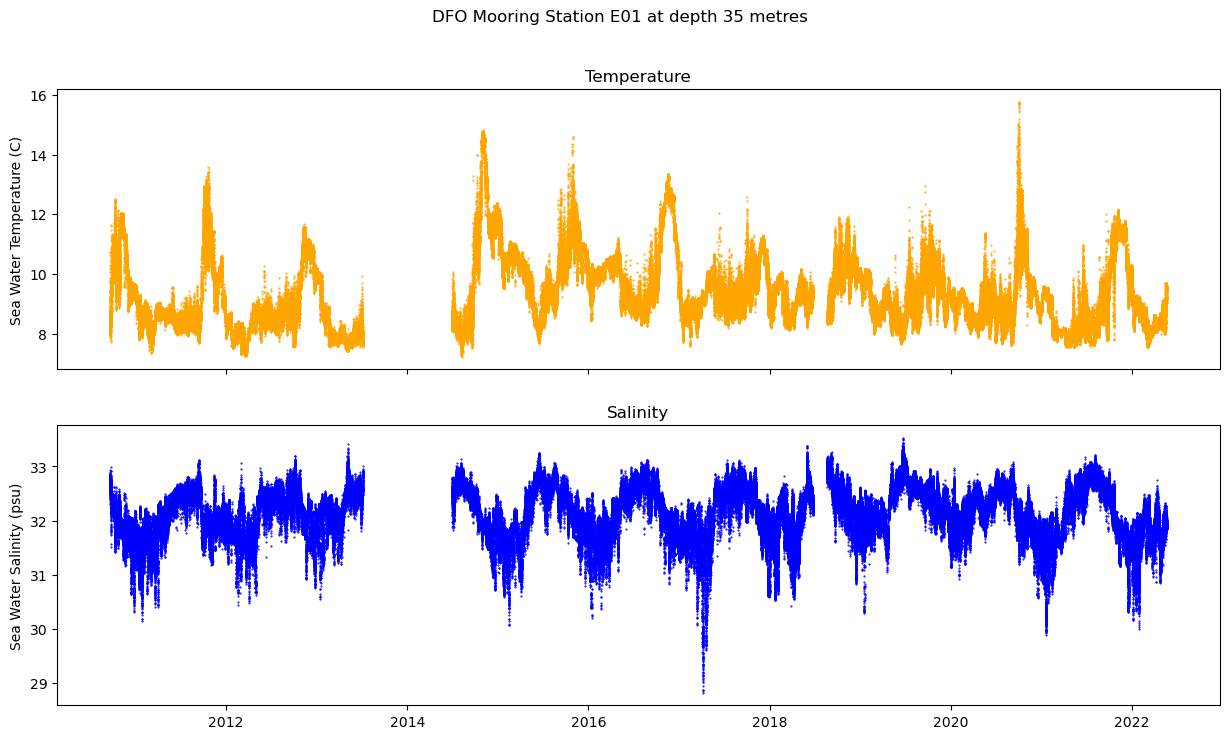

In [11]:
plot_dfo_E01_mooring(35)

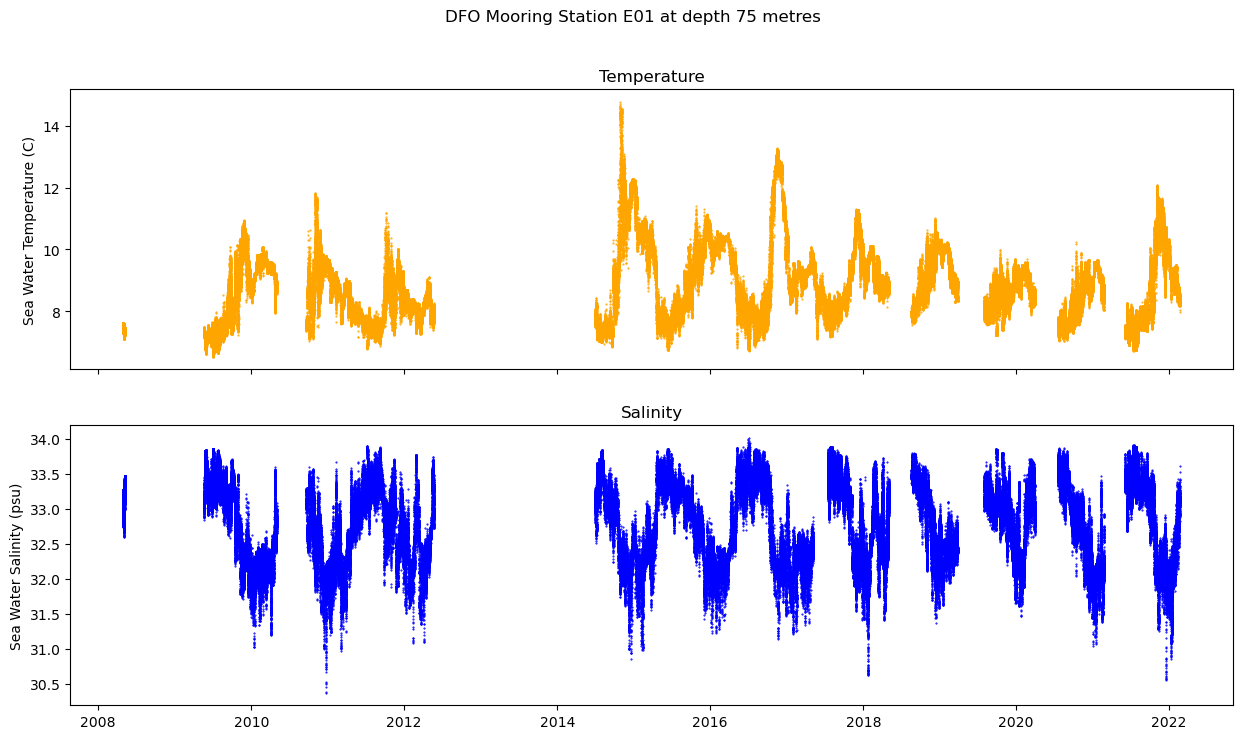

In [12]:
plot_dfo_E01_mooring(75)

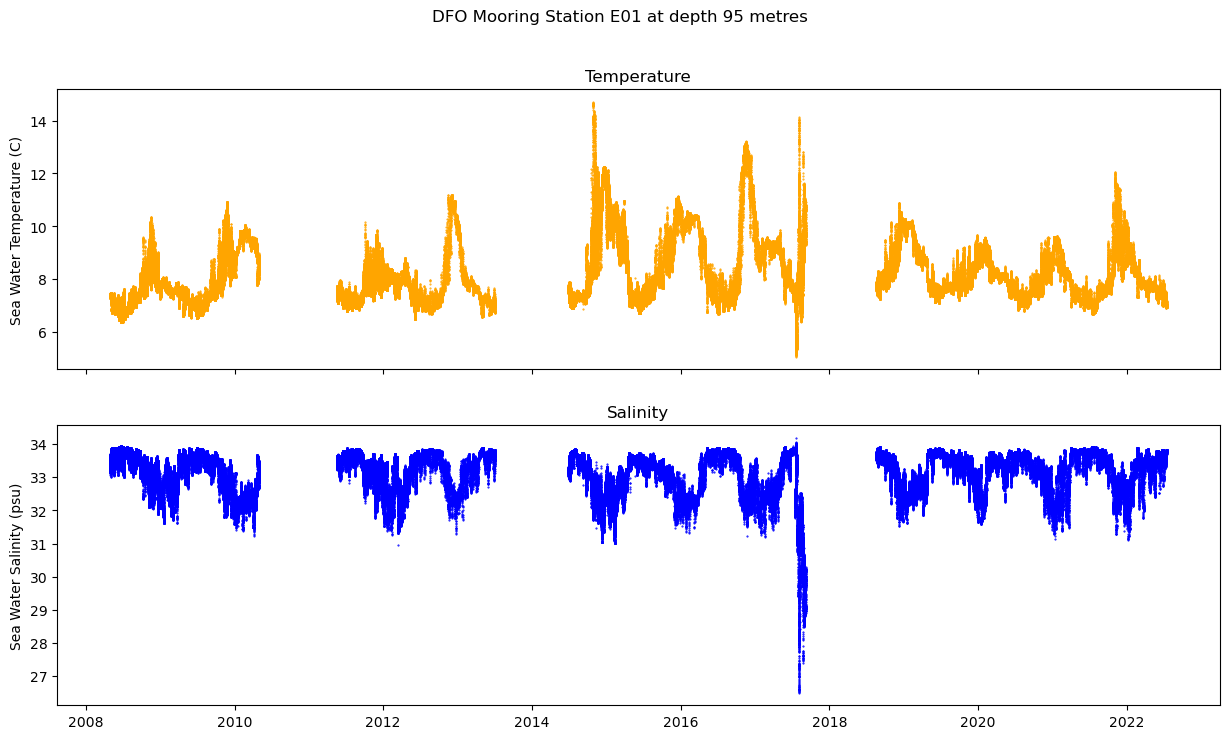

In [13]:
plot_dfo_E01_mooring(95)

### 6. Compare the temperature and salinity time series from three depths

In [14]:
def plot_dfo_E01_mooring(variable):
    cioos_e01_35 = cioos_table_1[(cioos_table_1["depth"] >= 30) & (cioos_table_1["depth"] <= 40)]
    cioos_e01_75 = cioos_table_1[(cioos_table_1["depth"] >= 70) & (cioos_table_1["depth"] <= 80)]
    cioos_e01_95 = cioos_table_1[(cioos_table_1["depth"] >= 90) & (cioos_table_1["depth"] <= 100)]
    
    newtime_35 = pd.DatetimeIndex(cioos_e01_35['time'].values)
    newtime_75 = pd.DatetimeIndex(cioos_e01_75['time'].values)
    newtime_95 = pd.DatetimeIndex(cioos_e01_95['time'].values)
    vars = list["Temperature", "Salinity"]
    
    if str(variable) == 'Temperature':
        #fig, ax = plt.subplots(1, figsize=(15, 8), sharex=True)
        fig, ax = plt.subplots()
        ax.plot(newtime_35, cioos_e01_35.sea_water_temperature, '.', markersize=1, c='#FF0000', label="35m", alpha=0.5)
        ax.plot(newtime_35, cioos_e01_35.TEMPST01, '.', markersize=1, c='#FF0000')
        ax.plot(newtime_75, cioos_e01_75.sea_water_temperature, '.', markersize=1, c='#FFA500', label="75m", alpha=0.5)
        ax.plot(newtime_75, cioos_e01_75.TEMPST01, '.', markersize=1, c='#FFA500')
        ax.plot(newtime_95, cioos_e01_95.sea_water_temperature, '.', markersize=1, c='#FFFF00', label="95m", alpha=0.5)
        ax.plot(newtime_95, cioos_e01_95.TEMPST01, '.', markersize=1, c='#FFFF00')
        ax.set_title('Temperature Time Series @ E01')
        ax.set_ylabel('Sea Water Temperature (C)')
        ax.legend(loc="upper left")
        #plt.suptitle(("DFO Mooring Station E01  {} time series".format(str(index)))
        plt.show()         
    elif str(variable) == 'Salinity':
        #fig, ax = plt.subplots(1, figsize=(15, 8), sharex=True)
        fig, ax = plt.subplots()
        ax.plot(newtime_35, cioos_e01_35.sea_water_pratical_salinity, '.', markersize=1, c='#7BC8F6', label="35m", alpha=0.5)
        ax.plot(newtime_75, cioos_e01_75.sea_water_pratical_salinity, '.', markersize=1, c='#0343DF', label="75m", alpha=0.5)
        ax.plot(newtime_95, cioos_e01_95.sea_water_pratical_salinity, '.', markersize=1, c='#0000FF', label="95m", alpha=0.5)
        ax.set_title('Salinity Time Series @ E01')
        ax.set_ylabel('Sea Water Salinity (psu)')
        ax.legend(loc="lower left")
        #plt.suptitle(("DFO Mooring Station E01  {} time series".format(str(index)))
        plt.show()                      
    else:
        print("Invalid input variable")                             
   

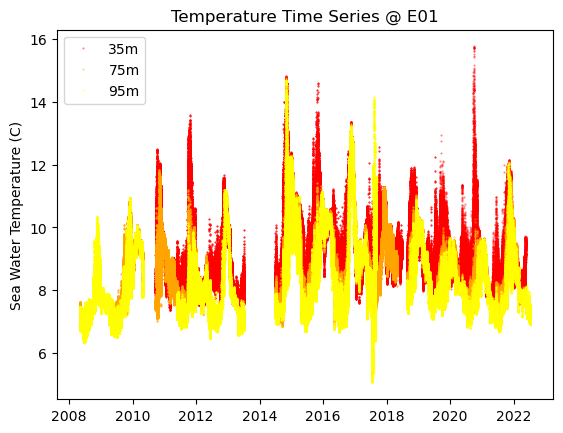

In [15]:
plot_dfo_E01_mooring("Temperature")

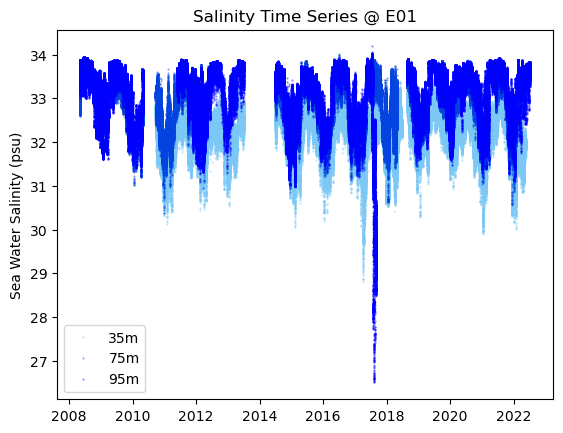

In [17]:
plot_dfo_E01_mooring("Salinity")

### 7. To do list:
      calculate and plot daily climatology
      calculate and plot daily anomalies